<a href="https://colab.research.google.com/github/mouraxy/room/blob/main/modelos/Anemia%20Level%20Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

  `Please upvote↑ if you find this helpful (suggestions are very welcome!)`
  
  *Author: copy the code to view the translations.

  <br>  
  
  #### 1. Objetivo e descrição...
  Implementação de um   `classificador multiclasse supervisionado` para identificar possíveis correlações entre diferentes graus de anemia infantil, em crianças de 0 a 59 meses, e dados do [Censo Demográfico e de Saúde da Nigéria](https://raw.githubusercontent.com/mouraxy/room/main/arquivos/children_anemia.csv) no ano de 2018.
  
  <br>

  Definação de cada um dos atributos do dataset:
  
  * **'idade_mae'**: Idade em grupos de 5 anos
  * **'local_residencia'**: Tipo de local da residência
  * **'nivel_educacional'**: Nível educacional mais alto
  * **'classe_social'**: Índice de riqueza
  * **'gestacoes'**: Nascimentos nos últimos cinco anos
  * **'idade_pri_nascimento'**: Idade do entrevistado no primeiro nascimento
  * **'nivel_hemoglobina'**: Nível de hemoglobina ajustado para altitude e tabagismo (g/dl - 1 decimal)
  * **'nivel_anemia'**: Nível de anemia da criança
  * **'mosquiteiro'**: Tem mosquiteiro para dormir
  * **'fuma'**: Fuma cigarros
  * **'estado_civil'**: Estado civil atual
  * **'residencia_parceiro'**: Atualmente reside com o marido/parceiro
  * **'tempo_amamentacao'**: Quando a criança foi amamentada
  * **'febre'**: Teve febre nas duas últimas semanas
  * **'nivel_hemoglobina2'**: Nível de hemoglobina ajustado para altitude (g/dl - 1 decimal)
  * **'nivel_anemia2'**: Nível de anemia da criança
  * **'medicacao'**: Tomando pílulas de ferro, [Sprinkles](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC545194/) ou xarope

  <br>

**_Palavras-chave:_** dados ausentes, duplicatas, codificação categórica, correlação, seleção de características, outliers, escalonamento, classes desbalanceadas, ajuste de hiperparâmetros, validação cruzada, modelagem.


  <!--
  Implementation of a supervised multiclass classifier to identify possible correlations between different degrees of childhood anemia, in children aged 0 to 59 months, and data from the [Nigerian Demographic and Health Census](https://raw.githubusercontent.com/mouraxy/ room/main/arquivos/children_anemia.csv) in 2018.


  **_Keywords:_** missing data, duplicates, categorical encoding, correlation, feature selection, outliers, scaling, imbalanced classes, hyperparameter tuning, cross-validation, modeling.
  -->






In [1]:
#print('Olá, você!')

  <br>

  #### 2. Importar bibliotecas...
  Preparação do ambiente de desenvolvimento. Isso é uma prática comum no início de scripts e notebooks Python para garantir que todas as dependências necessárias (funcionalidades que outras pessoas já escreveram) estejam disponíveis.

  <!--Preparing the development environment. This is common practice when starting Python scripts and notebooks to ensure that all the necessary dependencies (features that other people have already written) are available.
  -->

In [2]:

# ignora avisos no console
import warnings
warnings.filterwarnings("ignore")


In [3]:

# bibliotecas padrao
import os
import time
import requests

# bibliotecas matriciais
import numpy as np
import pandas as pd
import missingno as ms

# bibliotecas de machine learning
import joblib
from scipy.stats import zscore
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.preprocessing import MinMaxScaler, StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix

# bibliotecas de visualizacao de dados
import seaborn as sns
from tabulate import tabulate
import matplotlib.pyplot as plt


  <br>

  #### 3. Carga de dados...

  Etapa inicial em algoritmos de ML, refere-se à importação de dados obtidos de fontes externas para os ambientes de programação. Basicamente, é o primeiro passo para a construção do modelo.

  <!--
  The initial step in ML algorithms consists of importing data from external sources into programming environments. It's the first step to building a model.
  -->

In [4]:

# conecta-se a base de dados
url = 'https://raw.githubusercontent.com/mouraxy/room/main/arquivos/children_anemia.csv'

# altera os nomes das colunas
colunas = [
    'idade_mae',
    'local_residencia',
    'nivel_educacional',
    'classe_social',
    'gestacoes',
    'idade_pri_nascimento',
    'nivel_hemoglobina',
    'nivel_anemia',
    'mosquiteiro',
    'fuma',
    'estado_civil',
    'residencia_parceiro',
    'tempo_amamentacao',
    'febre',
    'nivel_hemoglobina2',
    'nivel_anemia2',
    'medicacao'
]

# le a base de dados
df_origem = pd.read_csv(
    url,
    delimiter=',',
    header=0,
    names=colunas,
    encoding='latin-1'
)


  
  <br>

  #### 4. Análise exploratória...

  A partir de agora, tentarei compreender o objeto de estudo e apoiar à formulação de hipóteses antes de avançar para análises mais complexas. Então, vamos explorar as características dos nossos dados!

  <!--
  From now on, I will try to understand the object of study and support the formulation of hypotheses before moving on to more complex analyses. So, let's explore the characteristics of our data!
  -->

In [5]:

def formatar__tabela(df):
    '''Retorna um tabela formatada para string
    Parametros:
    df:pd.DataFrame, tabela a ser formatada.
    '''
    tb = tabulate(
        df, headers="keys",
        tablefmt="simple_outline",
        showindex=False,
        numalign="left",
        floatfmt=".2f"
    )
    return tb


In [6]:

def gerar__metadados(df):
    '''
    Retorna metadados de uma tabela
    Parametros:
    df:pd.DataFrame, a tabela de onde os metadados serao gerados.
    '''
    # obtem os tipos de dados
    tipo_dados = df.dtypes

    # calcula a quantidade de nulos
    qtde_nulos = df.isnull().sum()
    estatisticas = df.describe(include='all').transpose()

    # cria um dataframe com algumas estatisticas
    df_metadados = pd.DataFrame({
    'Variável': tipo_dados.index,
    'Tipos de dados': tipo_dados.values,
    'Nulos': qtde_nulos.values,
    'Mínimo': estatisticas['min'],
    'Máximo': estatisticas['max'],
    'Média': estatisticas['mean'],
    })

    print(f'\n\nO DataFrame possui {df.shape[1]} colunas e {df.shape[0]} linhas:')
    print(formatar__tabela(df_metadados))

gerar__metadados(df_origem)




O DataFrame possui 17 colunas e 33924 linhas:
┌──────────────────────┬──────────────────┬─────────┬──────────┬──────────┬─────────┐
│ Variável             │ Tipos de dados   │ Nulos   │ Mínimo   │ Máximo   │ Média   │
├──────────────────────┼──────────────────┼─────────┼──────────┼──────────┼─────────┤
│ idade_mae            │ object           │ 0       │ nan      │ nan      │ nan     │
│ local_residencia     │ object           │ 0       │ nan      │ nan      │ nan     │
│ nivel_educacional    │ object           │ 0       │ nan      │ nan      │ nan     │
│ classe_social        │ object           │ 0       │ nan      │ nan      │ nan     │
│ gestacoes            │ int64            │ 0       │ 1.00     │ 6.00     │ 1.82    │
│ idade_pri_nascimento │ int64            │ 0       │ 12.00    │ 48.00    │ 19.57   │
│ nivel_hemoglobina    │ float64          │ 20788   │ 20.00    │ 218.00   │ 114.37  │
│ nivel_anemia         │ object           │ 20788   │ nan      │ nan      │ nan     │
│ mosq

  
  **Comentário:** Aparentemente, a tabela fornecida por @Adeola Adesina, contém `33.924 registros` e `17 variáveis`. Além disso...
  
  1. Sua composição é predominantemente `textual`. Isso significa que colunas catégoricas, como "fuma" e "febre", podem ter sido coletadas de forma qualitativa, por meio de entrevistas ou questionários.
  
  2. A `distribuição semelhante dos valores nulos` entre as varíaveis "nivel_hemoglobina" e "nivel_anemia", indica uma provável natureza quantitativa, ambos por diagnosticação médica.

  3. A `quantidade significativa de nulidades` sugere que os entrevistados podem não ter realizado o hemograma ou não tiveram acesso a esse tipo de exame. Também é possível que os resultados tenham sido perdidos ou corrompidos.

  4. Por último, a `similaridade entre os nomes das variáveis` "nível_hemoglobina", "nivel_anemia", "nivel_hemoglobina2" e "nivel_anemia2" levanta a hipótese: são realmente colunas duplicadas ou representam informações totalmente diferentes? A falta de documentação é o maior problema aqui.

<!--
  Comment: Apparently, the table provided by @Adeola Adesina, contains `33,924 records` and `17 variables`.
  
  - Its composition is predominantly `textual`. This means that categorical columns, such as "fuma" and "febre", may have been collected qualitatively, through interviews or questionnaires.
  
  - The similar `distribution of null values' between the variables "nivel_hemoglobina" and "nivel_anemia" indicates a probable quantitative nature, both by medical diagnosis.

  - The significant number of nulls suggests that the interviewees may not have had a full blood count or had no access to this type of test. It is also possible that the results were lost or corrupted.

  - Finally, the `similarity between the names of the variables` "haemoglobin_level", "anaemia_level", "haemoglobin_level2" and "anaemia_level2" raises the question: are they really duplicate columns or do they contain completely different information? The lack of documentation is the biggest problem here.
-->

  <br>

  #### 4.1 Duplicatas...

  Dados duplicados ameaçam a integridade dos dados, ao comprometer sua precisão e demandar maior alocação de recursos computacionais para armazenamento.



Duplicatas: 4678 (13.79%)


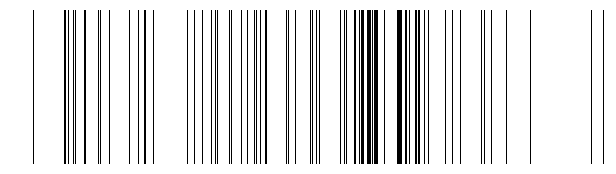

In [7]:

def calcular__duplicidades(df):
    '''
    Retorna a quantidade, porcentagem e um mapa de calor das duplicatas
    Parametros:
    df:pd.DataFrame, a tabela que sera analisada.
    '''
    # calcula as duplicatas
    duplicatas = df[df.duplicated()]
    porcentagem_duplicatas = (len(duplicatas) / len(df)) * 100
    print(f'\n\nDuplicatas: {len(duplicatas)} ({porcentagem_duplicatas:.2f}%)')

    # cria um mapa de calor
    plt.figure(figsize=(7.7, 2))
    sns.heatmap(
        df.duplicated().to_frame().transpose(),
        cmap='binary',
        cbar=False,
        xticklabels=False,
        yticklabels=False
    )

calcular__duplicidades(df_origem)


  
  **Comentário:** `4678` entradas do conjunto de dados são duplicatas, representando `13.79%` do conjunto de dados. Essa incidência, embora numericamente expressiva, pode ser atribuída principalmente à quantidade de campos que não apresentam dados. Isso ocorre porque, quanto menos informações distintas, maior é a probabilidade de duas ou mais linhas se repetirem.

  <!--
  Comment: 4678 entries in the dataset are duplicates, representing 13.79% of the dataset. This incidence, although numerically significant, can be attributed mainly to the number of fields that have no data. This is because the less distinct information there is, the more likely it is that two or more lines will be repeated.
  -->



  
  <br>

  #### 4.2 Distribuição e Heterogeneidade...

  Valores distintos indicam categorias ou comportamentos inesperados e evidenciam antecipadamente quais são as varíaveis mais promissoras.

  Por sua vez, a função "sumarizar__categorias" abaixo, realiza uma análise abrangente da distribuição quantitativa dos dados em cada variável categórica, fornecendo informações sobre seus valores distintos e o percentual em relação ao total. Eu desenvolvi essa abordagem para permitir uma síntese eficiente das colunas textuais, eliminando a necessidade de extensas linhas de código com bibliotecas de visualização.

  <!--
  Distinct values indicate unexpected categories or behaviors and show in advance which variables are the most promising.

  In this sense, the "summarize__categories" function below performs a comprehensive analysis of the quantitative distribution of the data in each categorical variable, providing information on its distinct values and the percentage in relation to the total. I developed this approach to allow efficient summarization of textual columns, eliminating the need for extensive lines of code with visualization libraries.
  -->

In [8]:

def sumarizar__categorias(df):
    '''
    retorna um sumario estatistico das variaveis de um dataframe
    Parametros:
    df:pd.DataFrame, um dataframe a ser analisado.
    '''
    df_sumario = pd.DataFrame()

    # itera sobre as colunas textuais
    for coluna in df.select_dtypes(include='object').columns:

        # calcula a distribuicao
        contagem = df[coluna].value_counts(normalize=True)
        top1, top2, *outros = contagem.index
        dados = [
            f'{coluna}',
            f"{top1} ({contagem[top1]*100:.2f}%)",
            f"{top2} ({contagem[top2]*100:.2f}%)",
            f"+{len(outros)} ({sum(contagem[outros])*100:.2f}%)"
        ]
        df_sumario[coluna] = dados

    # transpoe e renomeia as colunas
    return (df_sumario.transpose()
            .rename(columns={0: 'Variável', 1: 'Top 1', 2: 'Top 2', 3: 'Outros...'}))


In [9]:

resumo_categorico = sumarizar__categorias(df_origem)
print(f'\n\n{formatar__tabela(resumo_categorico)}')




┌─────────────────────┬──────────────────────────┬─────────────────────────────┬──────────────┐
│ Variável            │ Top 1                    │ Top 2                       │ Outros...    │
├─────────────────────┼──────────────────────────┼─────────────────────────────┼──────────────┤
│ idade_mae           │ 25-29 (27.92%)           │ 30-34 (22.54%)              │ +5 (49.54%)  │
│ local_residencia    │ Rural (65.51%)           │ Urban (34.49%)              │ +0 (0.00%)   │
│ nivel_educacional   │ No education (45.37%)    │ Secondary (31.31%)          │ +2 (23.32%)  │
│ classe_social       │ Poorest (23.78%)         │ Poorer (22.82%)             │ +3 (53.40%)  │
│ nivel_anemia        │ Not anemic (40.63%)      │ Moderate (30.25%)           │ +2 (29.12%)  │
│ mosquiteiro         │ Yes (70.79%)             │ No (29.21%)                 │ +0 (0.00%)   │
│ fuma                │ No (99.79%)              │ Yes (0.21%)                 │ +0 (0.00%)   │
│ estado_civil        │ Married (92.04

  
  **Comentário:** Vou fazer um resumo dos dados, explorando as características predominantes entre eles:

  1. No âmbito socioeconômico, a faixa etária mais comum entre as mães situa-se entre `25 e 29` anos. A maioria também reside em áreas rurais e possui níveis educacionais e econômicos limitados, com `45.37%` sem educação formal e `46.60%` vivendo na pobreza ou extrema pobreza.

  2. No que diz respeito à saúde, as mães são quase integralmente não fumantes, não tiveram febre recentemente e também a maioria não faz uso de medicação regular, a prática da amementação também é comum.

  <!--
  Comment: I'm going to summarize the data, exploring the predominant characteristics among them:

  On the socioeconomic front, the most common age group among mothers is between 25 and 29. The majority also live in rural areas and have limited educational and economic levels, with 45.37% having no formal education and 46.60% living in poverty or extreme poverty.

  As far as health is concerned, the mothers are almost entirely non-smokers, they haven't had a fever recently and most of them don't take regular medication, breastfeeding is also common.
 -->





  <br>

  #### 4.2.1 Variável alvo...
  A variável alvo é o principal resultado ou característica que se busca prever ou entender em um modelo estatístico ou de aprendizado de máquina. Antecipar os seus resultados é o objetivo!

  <!--
  The target variable is the main result or characteristic that you want to predict or understand in a statistical or machine learning model. Anticipating its results is the goal!
  -->

In [10]:
variavel_alvo = 'nivel_anemia'


  <br>  

  #### 4.2.1.1 Distribuição das variáveis preditoras/alvo...
  Fazer esse tipo de análise pode indicar se o problema é balanceado, onde as classes da variável-alvo têm números semelhantes de instâncias, ou desbalanceado, onde uma classe é significativamente mais frequente do que a outra.

  Em geral, um modelo treinado em um conjunto de dados com classes desproporcionais pode desenvolver vieses e ter dificuldade em generalizar, com sua acurácia não sendo verdadeira.

  <!--
  Doing this type of analysis can indicate whether the problem is balanced, where the classes of the target variable have similar numbers of instances, or unbalanced, where one class is significantly more frequent than the other.

  In general, a model trained on a data set with disproportionate classes can develop biases and have difficulty generalizing, and its accuracy may not be true.
  -->

In [11]:

# altera a fonte
sns.set(font_scale=.8)

# adiciona linhas de grade
sns.set_style("whitegrid", {'axes.grid' : True})


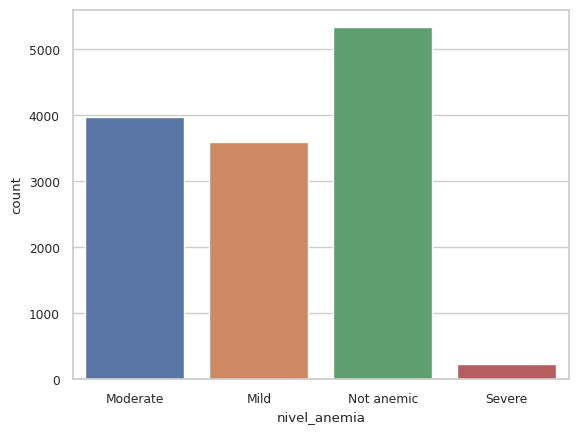

In [12]:

sns.countplot(data=df_origem, x=variavel_alvo);


  
  **Comentário:** Há um grande desequilíbrio em nossa variável-alvo. A classe que representa o nível mais severo, é muito menor do que os outros, o que faz sentido, porque sua classe indica um caso extremo.

  Mas antes de qualquer tratativa, eu preciso explicar do porquê eu não vou agrupar as 4 classes em um par booleano. Sinceramente, eu poderia trabalhar com um classificador binário, porém, isso simplificaria demais o problema e todo o desenvolvimento do código, então manterei a quantidade de categorias intactas.

  <!--
  Comment: there is a big imbalance in our target variable. The class representing the most severe level is much smaller than the others, which makes sense because its class indicates an extreme case.

  But before I do anything, I need to explain why I'm not going to group the 4 classes into a Boolean pair. Honestly, I could work with a binary classifier, but that would simplify the problem and the whole code development too much, so I'll keep the number of categories intact.
  -->

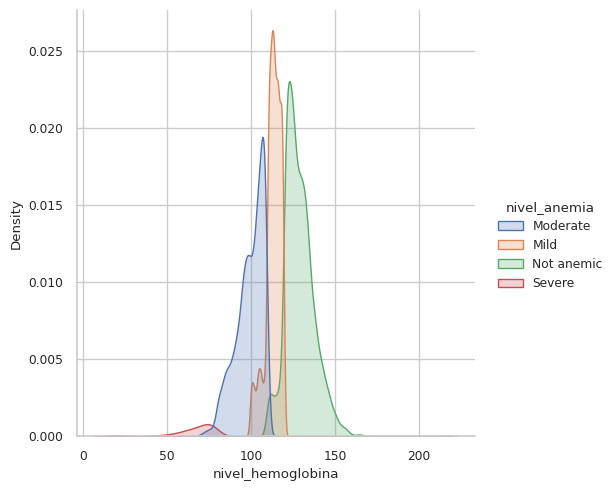

In [13]:

sns.displot(df_origem, x='nivel_hemoglobina', hue=variavel_alvo, kind="kde", fill=True);


  
  **Comentário:** A densidade de hemoglobina tem relação direta com as classes. Quanto menor os níveis de hemoglobina no sangue, maior a severidade da condição anêmica.

  <!--
  Comment: Hemoglobin density is directly related to the classes. The lower the hemoglobin levels in the blood, the greater the severity of the anemic condition.
  -->

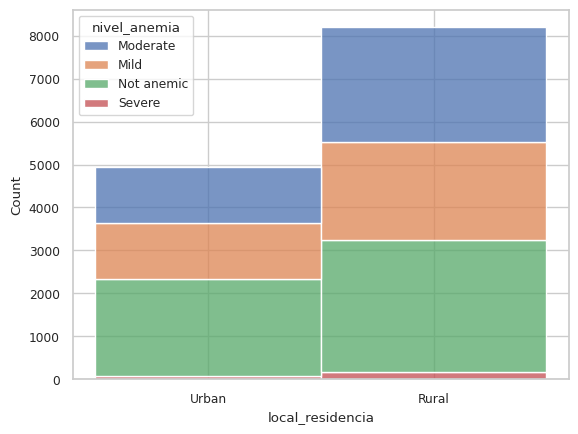

In [14]:

sns.histplot(df_origem, x='local_residencia', hue=variavel_alvo, multiple='stack');



  **Comentário:** A maior concentração de anêmicos está localizado nas zonas rurais. Nesta região, a proporção de casos moderados e severos é maior.

  <!--
  **Comment:** The highest concentration of anemic people is located in rural areas. In this region, the proportion of moderate and severe cases is higher.
  -->

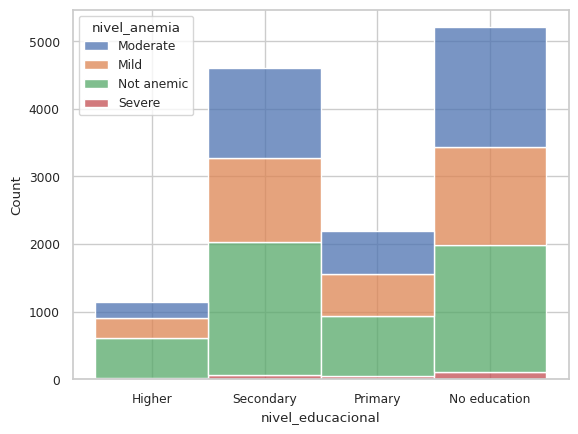

In [15]:

sns.histplot(df_origem, x='nivel_educacional', hue=variavel_alvo, multiple='stack');


  
  **Comentário:** A maior concentração de anêmicos pertence às pessoas sem escolaridade. Semelhantemente ao local de residência, a proporção de casos moderados e severos para esse grupo também é maior.

  <!--
  Comment: The highest concentration of anemic people belongs to those with no schooling. Similar to the place of residence, the proportion of moderate and severe cases for this group is also higher.
  -->

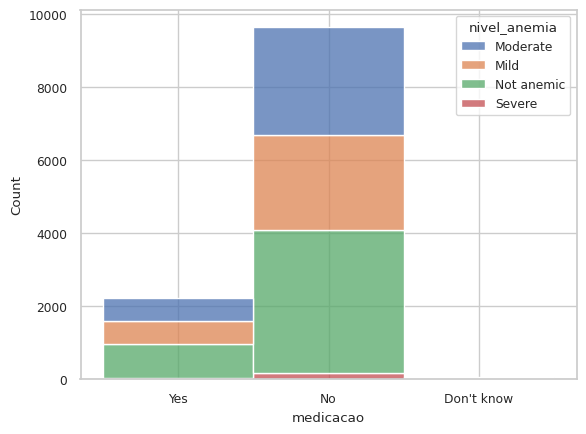

In [16]:

sns.histplot(df_origem, x='medicacao', hue=variavel_alvo, multiple='stack');



  **Comentário:** Aqui é possível perceber a conexão entre a administração de medicamentos para tratar a anemia e os níveis nas crianças. Por sua vez,observa-se uma concentração significativa de pessoas que não estão recorrendo à medicação. Consequentemente, os casos mais graves estão particularmente presentes entre aqueles que não adotam esse tipo de tratamento.

  <!--
  Comment: Here it is possible to see the connection between the administration of medication to treat anemia and the corresponding levels of this condition in children. Of course, there is a significant concentration of people who are not taking medication. Consequently, the most serious cases are particularly present among those who do not adopt this type of treatment.
  -->

  

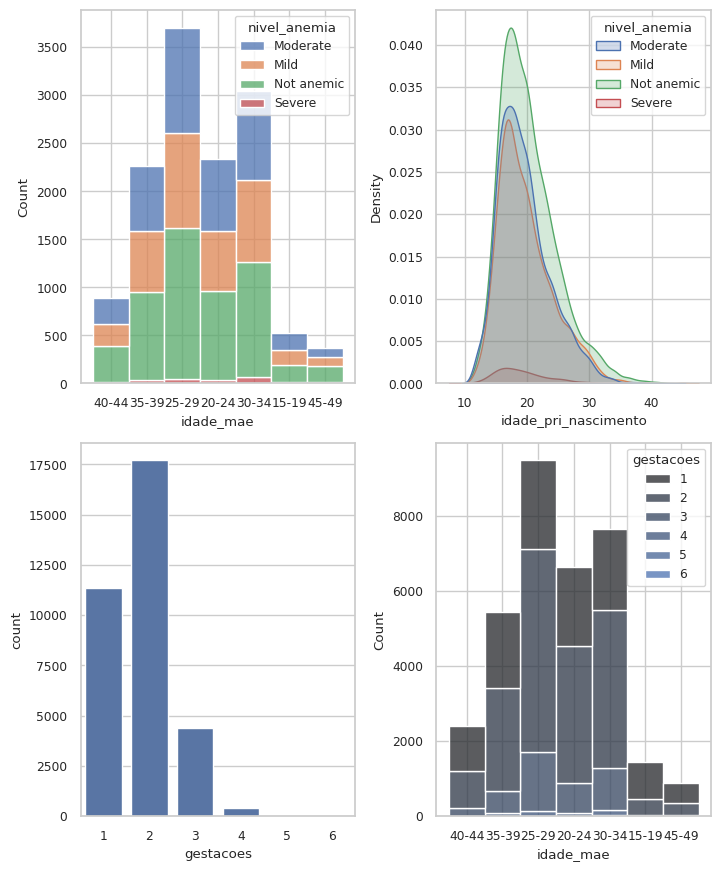

In [17]:
fig, axes = plt.subplots(2, 2, figsize=(7.3, 8.8))

sns.histplot(df_origem, x='idade_mae', hue=variavel_alvo, multiple='stack', ax=axes[0, 0])
sns.kdeplot(data=df_origem, x='idade_pri_nascimento', hue=variavel_alvo, fill=True, ax=axes[0, 1])
sns.histplot(data=df_origem, x='idade_mae', hue='gestacoes', multiple='stack', palette='dark:b', ax=axes[1, 1])
sns.countplot(data=df_origem, x='gestacoes', color='C0', ax=axes[1, 0])

fig.tight_layout()

  
  **Comentário:** Com os 4 gráficos acima podemos considerar o seguinte:
  1.  Mães com idades entre 25 e 29 anos apresentam uma incidência mais significativa de crianças com idades entre 0 e 59 meses em condições anêmicas.
  2.  A faixa etária mais comum para o nascimento do primeiro filho situa-se entre 16 e 19 anos.
  3.  A maioria das mães com filhos anêmicos tiveram sua primeira gestação antes dos 20 anos de idade.
  4.  A maioria das mães registra pelo menos duas gestações nos últimos 5 anos.
  
  
  <!--
  Comment: With the 4 graphs above we can consider the following:
  1.  Mothers aged between 25 and 29 have a higher incidence of children aged between 0 and 59 months in anemic conditions.
  2.  The most common age group for the birth of the first child is between 16 and 19 years.
  3.  Most mothers with anemic children had their first pregnancy before the age of 20.
  4.  Most mothers have had at least two pregnancies in the last 5 years.
  -->

  
  <br>

  #### 5. Pré-processamento dos dados...
  Vou agora manipular os dados brutos para adequá-los a um formato mais propício.  Primeiro, removerei todas as entradas indesejadas, como registros incompletos e duplicatas. Com isso, os modelos se tornarão mais imparciais.

  <!--
  I'm now going to manipulate the raw data to fit a more favorable format.  First, I'll remove all unwanted entries, such as incomplete records and duplicates. This will make the models more unbiased.
  -->



In [18]:

def excluir__linhas(df, variavel_alvo):
    '''
    retorna um dataframe sem duplicatas ou nulidades
    Parametros:
    df:pd.DataFrame, o dataframe a ser limpo
    variavel_alvo:str, nome da variavel-alvo.
    '''
    df_limpo = (
        # cria uma copia do dataframe
        df_origem.copy()
        # exclui duplicatas
        .drop_duplicates()
        # exclui nulidades
        .dropna(subset=[
            variavel_alvo,
            'nivel_hemoglobina',
            'nivel_educacional',
            'medicacao'
        ])
        # altera valores nulos para a mediana
        .fillna(df_origem.median())
    # altera os valores nulos residuais
    ).fillna('n/d')

    return df_limpo


  
  <br>

  #### 5.0.1 Matriz de não nulos...
  A msno.matrix é uma exibição densa que permite obter um rápido resumo visual da integridade (ou falta dela) de um conjunto de dados, sendo possível identificar valores ausentes.

  <!--
  msno.matrix is a dense display that allows you to get a quick visual summary of the completeness (or lack thereof) of a data set, and you can identify missing values.
  -->

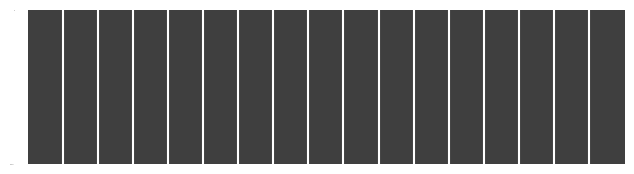

In [19]:

df_limpo = excluir__linhas(df_origem, variavel_alvo)
ms.matrix(df_limpo, fontsize=0, labels=False, sparkline=False, figsize=(7.7, 2));


  
  **Comentário:** Trabalharei apenas com cópias de daframes. Isso possibilitará análises individuais de cada etapa caso seja necessário. Quanto a função, todos os dados nulos foram removidos ou substituídos, pela mediana ou agrupados com um texto específico. Os dados duplicados identificados anteriormente no tópico 4.1, também fora retirados do conjunto de dados.

  <!--
  Comment: I will only be working with copies of daframes. This will make it possible to analyze each step individually if necessary. As for the function, all null data has been removed or replaced by the median or grouped with a specific text. The duplicate data identified earlier in topic 4.1 has also been removed from the dataset.
  -->

  
  <br>

  #### 5.1 Codificação textual...
  O próximo passo é atribuir um número inteiro único para cada variável categórica. Cada rótulo será mapeado para um número inteiro, facilitando o uso dessas variáveis em algoritmos que exigem entradas numéricas. Também, guardarei um dicionário com as categorias originais e seus correspondentes numéricos após a transformação. Com isso, poderei identificar os resultados em uma possível de predição.

  <!--
  The next step is to assign a unique integer to each categorical variable. Each label will be mapped to an integer, making it easier to use these variables in algorithms that require numerical entries. I will also keep a dictionary with the original categories and their numerical correspondents after the transformation. With this, I will be able to identify the results in a possible prediction.
  -->

In [20]:

def codificador__textual(df):
    '''
    retorna um dataframe codificado numericamente e um dicionario
    que mapeia os valores numericos de volta para seus valores originais
    Parametros:
    df:pd.DataFrame, o daframe com variaveis categoricas a serem descodificadas.
    '''
    descodificador = {}
    # cria uma copia do dataframe
    df_numerico = df.copy()

    # itera sobre as colunas textuais
    for coluna in df.select_dtypes(include=['object']).columns:
      le = LabelEncoder()

      # altera os valores categoricos em numericos
      df_numerico[coluna] = le.fit_transform(df[coluna])

      # cria um armazenamento para as classes originais e seus valores numericos
      descodificador[coluna] = dict(zip(le.classes_, le.transform(le.classes_)))

    return df_numerico, descodificador


In [21]:
df_numerico, descodificador = codificador__textual(df_limpo)


  <br>

  #### 5.2 Correlação...
  A matriz de correlação é uma tabela simétrica que quantifica como as variáveis estão relacionadas umas com as outras, variando de -1 a 1. É essencial visualização para identificar as características mais importantes dos nossos dados.

  <!--
  The correlation matrix is a symmetrical table that quantifies how variables are related to each other, ranging from -1 to 1. It is essential to visualize in order to identify the most important characteristics of our data.
  -->

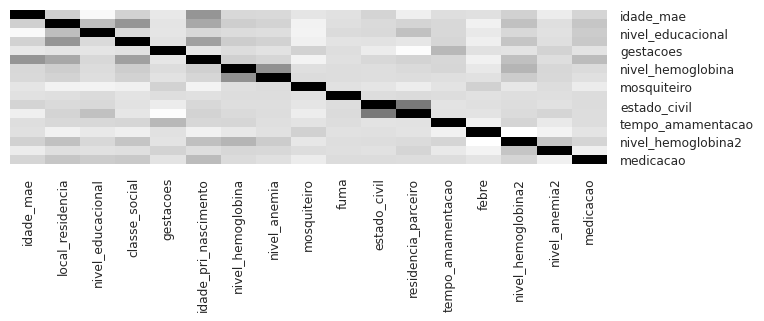

In [22]:
plt.figure(figsize=(7.7, 2))
heatmap = sns.heatmap(df_numerico.corr().T, cbar=False, cmap='binary').tick_params(axis='y', labelrotation=0,
                                                                                   labelright=True, labelleft=False)

  
  **Comentário:** Conforme a matriz de correlação, são poucas colunas que possuem um alto grau correlativo com a condição anêmica das crianças, com excessão principalmente do nível de hemoglobina (g/dl).

  <!--
  Comment: According to the correlation matrix, there are few columns that have a high degree of correlation with the children's anemic condition, with the main exception of the hemoglobin level (g/dl).
  -->

  
  <br>

  #### 5.2.1 Redimensionar dados...
  A seguir, remodelarei a nossa tabela, selecionando apenas as variáveis mais relevantes para o problema. Isto é, correlações significativas. Também desconsiderarei colunas muito semelhantes umas com as outras para evitar um problema chamado [multicolinearidade](https://pt.wikipedia.org/wiki/Multicolinearidade).

  <!--
  Next, I will reshape our table, selecting only the variables that are most relevant to the problem. That is, significant correlations. I will also disregard columns that are very similar to each other to avoid a problem called multicollinearity
  -->

In [23]:

def excluir__colunas(df, correlacao, correlacao_min=0.3, correlacao_max=0.95):
    '''
    retorna um daframe com menos colunas
    Parametros:
    df:pd.DataFrame, o dataframe contendo as variaveis numericas
    correlacao:pd.DataFrame, a matriz de correlação entre as variaveis
    correlacao_min:float, o limite inferior para a correlacao entre variaveis e a variavel-alvo
    correlacao_max:float, o limite superior para a correlacao entre variaveis e a variavel-alvo.
    '''
    # seleciona colunas com correlacao dentro dos limites especificados
    colunas_selecionadas = correlacao[((correlacao[variavel_alvo].abs() >= correlacao_min) &
    (correlacao[variavel_alvo].abs() < correlacao_max))].index.tolist()

    # seleciona colunas que nao deverao ser
    colunas_selecionadas += [
        variavel_alvo, 'idade_mae',
        'idade_pri_nascimento', 'local_residencia',
        'nivel_educacional', 'medicacao'
    ]
    return df[list(set(colunas_selecionadas))]


In [24]:
df_redimensionado = excluir__colunas(df_numerico, df_numerico.corr())


  <br>

  #### 5.3 Outliers...
  Pontos de dados que se desviam significativamente do padrão geral de um conjunto, os outiliers distorcem análises estatísticas, sendo sua identificação crucial para preservar a integridade e precisão dos dados.

  <!--
  As data points that deviate significantly from the general pattern of a set, outliers distort statistical analysis, and their identification is crucial to preserving the integrity and accuracy of the data.
  -->
  

In [25]:

def localizar__outliers(df, limiar=3):
    '''
    retorna um dataframe com a quantidade de outliers por coluna
    Parametros:
    df:pd.DataFrame, o dataframe contendo as variáveis a serem analisadas
    limiar:float, o limiar para identificar outliers com a pontuação z
    '''
    df_outliers = pd.DataFrame(columns=['Variável', 'Outliers localizados'])

    # itera sobre as colunas do dataframe
    for coluna in df.columns:
        # calcula as pontuações z
        z_scores = zscore(df[coluna])
        # identifica outilers com base no limiar
        outliers = df[(z_scores > limiar) | (z_scores < -limiar)]
        # calcula a quantidade de outliers
        quantidade_outliers = len(outliers)
        df_outliers = df_outliers.append({'Variável': coluna, 'Outliers localizados': quantidade_outliers}, ignore_index=True)
    return df_outliers


In [26]:
print(formatar__tabela(localizar__outliers(df_redimensionado)))

┌──────────────────────┬────────────────────────┐
│ Variável             │ Outliers localizados   │
├──────────────────────┼────────────────────────┤
│ local_residencia     │ 0                      │
│ medicacao            │ 0                      │
│ idade_pri_nascimento │ 106                    │
│ nivel_hemoglobina    │ 80                     │
│ nivel_anemia         │ 0                      │
│ nivel_educacional    │ 0                      │
│ idade_mae            │ 0                      │
└──────────────────────┴────────────────────────┘



  <br>

  #### 5.3.1 Boxplot dos outliers
  O boxplot é um resumo da distribuição dos dados. Ele consiste em uma caixa que abrange o intervalo interquartil (IQR), representando 50% do conjunto de dados com uma mediana. Além da caixa, o boxplot possui linhas de whisker que se estendem até uma certa distância da maioria das informações. Pontos fora dessas linhas são potenciais outliers, ou seja, valores extremos.

  <!--
  The boxplot is a summary of the data distribution. It consists of a box covering the interquartile range (IQR), representing 50% of the data set with a median. In addition to the box, the boxplot has whisker lines that extend to a certain distance from most of the information. Points outside these lines are potential outliers, i.e. extreme values.
  -->


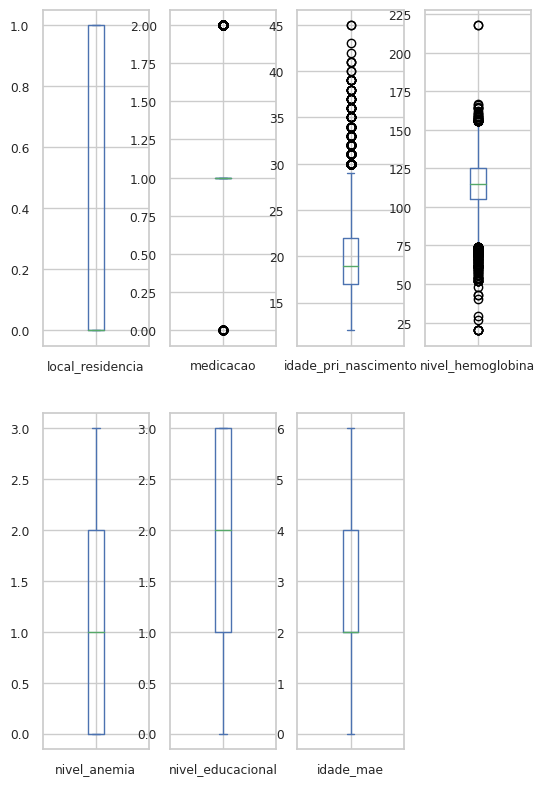

In [27]:

# obtem a quantidade de linhas para os subplots
linhas_grafico = (df_redimensionado.shape[1] + 4 - 1) // 4

df_redimensionado.plot(
    kind='box',
    subplots=True,
    grid=True,
    layout=(linhas_grafico, 4),
    figsize=(6.3, (linhas_grafico)*4.8)
);



  **Comentário:** Identifiquei valores discrepantes na variável "nivel_hemoglobina", no entanto, não acredito que tenha sido uma falha na entrada de dados. Assim, como o nível de hemoglobina é um dado coletado e atestado laboratorialmente por especialistas, não os removerei.
  
  <!--
  Comment: I've identified discrepant values in the "hemoglobin_level" variable, but I don't believe it was a fault in the data entry. Therefore, as the hemoglobin level is data collected and laboratory-verified by specialists, I will not remove them.
  -->


  <br>

  #### 5.4 Preparação do conjunto de treino e teste...
  Essa etapa inclui a separação das variáveis preditoras (ou features) da variável alvo, bem como a divisão do conjunto de dados em conjuntos de treino e teste. Isso é importante principalmente por dois motivos:

  1.   Generalizar melhor os dados, pois, ao testar modelos em conjuntos de dados que nunca foram utilizados durante o treinamento, é possível atenuar o viés e reduzir possíveis tendenciosidades, garantindo que o modelo seja mais aplicável a cenários do mundo real.
  2.   Evitar o vazamento de dados, que ocorre quando informações do conjunto de teste influenciam o treinamento do modelo.

<!--
  This step includes separating the predictor variables (or features) from the target variable, as well as dividing the data set into training and test sets. This is important for two main reasons:

  1.   To better generalize the data, because by testing models on data sets that were never used during training, it is possible to mitigate bias and reduce possible biases, ensuring that the model is more applicable to real-world scenarios.
  2.   Avoid Data Leakage, which occurs when information from the test influences the training of the model.
-->



In [28]:

def dividir__dados(df):
    '''
    retorna a divisao do daframe em variaveis preditoras e variavel-alvo
    Parametros:
    df:pd.DataFrame, o dataframe com as variaveis preditoras e a variavel-alvo.
    '''
    # separa as variaveis preditoras e a variavel-alvo
    X = df.drop(variavel_alvo, axis=1)
    y = df[variavel_alvo]
    return X, y


In [29]:

# divide o conjunto de dados em treino e teste
X, y = dividir__dados(df_redimensionado)
X_treino, X_teste, y_treino, y_teste = train_test_split(X, y, test_size=0.3, random_state=42)

print(
    formatar__tabela(pd.DataFrame
     ({
    'target?': [False, True],
    'qtde_linhas': [X.shape[0], y.shape[0]],
    'qtde_colunas': [X.shape[1], 1]
    }))
)


┌───────────┬───────────────┬────────────────┐
│ target?   │ qtde_linhas   │ qtde_colunas   │
├───────────┼───────────────┼────────────────┤
│ False     │ 11906         │ 6              │
│ True      │ 11906         │ 1              │
└───────────┴───────────────┴────────────────┘



  **Comentário:** Como podemos ver, foram separados os dados que serão utilizados para o treino do modelo e os dados que serão utilizados como teste.
  
  Ambos possuem a mesma quantidade de linhas, no entanto, a variável-alvo é uma série do pandas com as classes que quero prever ("nivel_anemia"), já as variaveis preditoras foram divididas em um outro daframe com três colunas e serão usadas para fazer com que os nossos modelos aprendam os padrões necessários.

  <!--
  Comment: As we can see, the data that will be used to train the model and the data that will be used to test it have been separated.
  
  Both have the same number of rows, however, the target variable is a series of pandas with the classes I want to predict ("level_anemia"), while the predictor variables have been divided into another daframe with three columns and will be used to make our models learn the necessary patterns.
  -->


  <br>

  #### 5.5 Balanceamento...
  Lidaremos agora com o desequilíbrio da variável alvo, já que existem classes com muito mais amostras do que outras, o que pode tendenciar os modelos.

  <!--
  We will now deal with the imbalance of the target variable, since there are classes with many more samples than others, which can bias the models.
  -->

In [30]:

# balanceamento das variaveis
X_treino_ros, y_treino_ros = RandomOverSampler().fit_resample(X_treino, y_treino)
X_treino_rus, y_treino_rus = RandomUnderSampler().fit_resample(X_treino, y_treino)


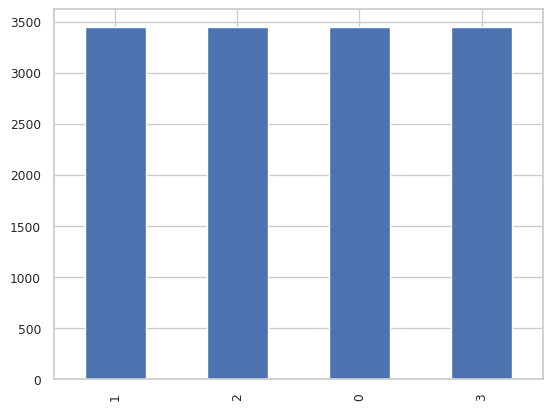

In [31]:
y_treino_ros.value_counts().plot(kind = 'bar', grid=True, figsize=(6.3, 4.8));

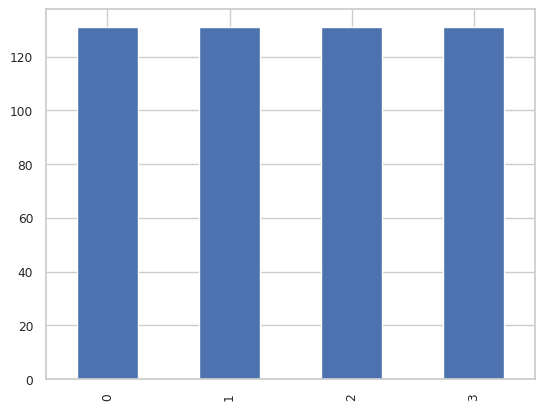

In [32]:
y_treino_rus.value_counts().plot(kind = 'bar', grid=True, figsize=(6.3, 4.8));


  **Comentário:** Equilibrei as classes e agora todas possuem a mesma quantidade de valores. Para isso, adotei o balanceamento por undersampling (subamostragem) e oversampling (sobreamostragem), visando atingir uma distribuição igualitária entre as classes e criar um ambiente propício para o treinamento de modelos generalizáveis.

  <!--
  Comment: I balanced the classes and now they all have the same number of values. To do this, I used undersampling and oversampling to achieve an equal distribution between the classes and create an environment conducive to training generalizable models.
  -->



  <br>

  #### 5.6 Padronização dos dados...
  Aqui ajustarei a escala dos dados para que estejam em uma faixa específica. Isso garantirá que diferentes características ou variáveis tenham uma influência mais equitativa em algoritmos de ML.

  <!--
  Here I will adjust the scale of the data so that it is in a specific range. This will ensure that different characteristics or variables have a more equitable influence on ML algorithms.
  -->


In [33]:

# padronizar as variaveis preditoras
sc = StandardScaler()
X_treino_sc = sc.fit_transform(X_treino)
X_treino_ros_sc = sc.fit_transform(X_treino_ros)
X_treino_rus_sc = sc.fit_transform(X_treino_rus)
X_teste_sc = sc.transform(X_teste)


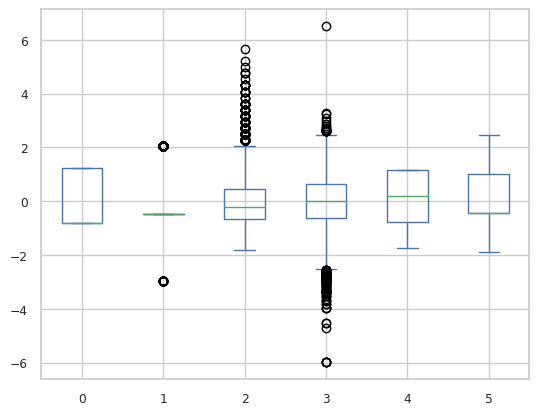

In [34]:
pd.DataFrame(X_treino_sc).plot(kind = 'box', grid=True, figsize=(6.3, 4.8));

  
  <br>

  **Comentário:** Todas as variáveis preditoras foram escalonadas para o mesmo padrão. Isso deixará os valores das colunas com valores semelhantes.





  
  <br>

  #### 5.7. Configurações...
  Armazenarei diferentes configurações em uma lista de tuplas e cada opção será testada para avaliar os seus desempenhos individuais. Entre as escolhas estão:

  `1.   Classes balanceadas (↑) | dados não padronizados`<br>
  `2.   Classes balanceadas (↓) | dados não padronizados`<br>
  `3.   Classes balanceadas (↑) | dados padronizados`<br>
  `4.   Classes balanceadas (↓) | dados padronizados`<br>
  `5.   Classes não balanceadas | dados padronizados`<br>
  `6.   Classes não balanceadas | dados não padronizados`
  
  <!--
  I will store different configurations in a list of tuples and each option will be tested to evaluate their individual performances. Entre as escolhas estão:

  `1.   Balanced classes (↑) | non-standardized data
  `2.   Balanced classes (↓) | unstandardized data
  `3.   Balanced classes (↑) | standardized data
  `4.   Balanced classes (↓) | standardized data
  `5.   Unbalanced classes | standardized data
  `6.   Unbalanced classes | non-standardized data
  -->

In [35]:

configuracoes = [
    ('ros', X_treino_ros, y_treino_ros, X_teste, y_teste),
    ('rus', X_treino_rus, y_treino_rus, X_teste, y_teste),
    ('ros_sc', X_treino_ros_sc, y_treino_ros, X_teste_sc, y_teste),
    ('rus_sc', X_treino_rus_sc, y_treino_rus, X_teste_sc, y_teste),
    ('sc', X_treino_sc, y_treino, X_teste_sc, y_teste),
    ('nd', X_treino, y_treino, X_teste, y_teste),
]


  
  <br>

  #### 6. Modelagem (**opcional**)...
  Iniciarei a etapa de modelagem criando um dicionário para armazenar informações sobre os resultados dos modelos. As chaves do dicionário representam diferentes métricas de desempenho que eu preencherei com os resultados específicos de cada execução.

  <!--
  I'll start the modeling stage by creating a dictionary to store information about the model results. The keys in the dictionary represent different performance metrics that I will fill in with the specific results of each run.
  -->


In [36]:

df_metricas = {
    'Configuração': [],
    'Modelo': [],
    'Acurácia': [],
    'Precision': [],
    'Recall': [],
    'F1-score': [],
    'ROC AUC': [],
    'Treinamento (s)': []
}


In [37]:

def calcular__metricas(y_teste, y_pred, y_pred_proba):
    '''Retorna um dicionário com as metricas dos modelos
    Parametros:
    y_teste: rotulos do conjunto de teste
    y_pred:array, previsoes do modelo para o conjunto de teste
    y_pred_proba:array, probabilidades para cada classe.
    '''
    metricas = {
        'acurácia': accuracy_score(y_teste, y_pred),
        'precision': precision_score(y_teste, y_pred, average='weighted'),
        'recall': recall_score(y_teste, y_pred, average='weighted'),
        'f1_score': f1_score(y_teste, y_pred, average='weighted'),
        'roc_auc': roc_auc_score(y_teste, y_pred_proba, multi_class='ovr'),
    }

    return metricas


  
  <br>

  #### 6.1 Algoritmos...
  Por serem amplamente utilizados em tarefas de classificação multiclasse, escolhi treinar os modelos RandomForest e GradientBoosting para me beneficiar das características distintas oferecidas por cada algoritmo.
  
  <!--
  Because they are widely used in multiclass classification tasks, I chose to train the RandomForest and GradientBoosting models in order to benefit from the distinct characteristics offered by each algorithm.
  -->







In [38]:

modelos = {
    'RandomForest': RandomForestClassifier(random_state=42),
    'GradientBoosting': GradientBoostingClassifier(random_state=42)
}


  
  <br>

  #### 6.2 Hiperparâmetros...
  Abaixo, vou definir uma lista de hiperparâmetros para otimizar o treinamento dos algoritmos. Assim, poderei futuramente procurar diferentes combinações para encontrar o conjunto ideal que maximiza os desempenhos dos modelos.

  <!--
  Below, I will define a list of hyperparameters to optimize the training of the algorithms. This way, I'll be able to search for different combinations to find the ideal set that maximizes the models' performance.
  -->


In [39]:

'''
hiperparametros = {
  'RandomForest': {'n_estimators': [...], 'max_depth': [...]}
  'GradientBoosting': {'n_estimators': [...], 'max_depth': [...]}
}
'''


"\nhiperparametros = {\n  'RandomForest': {'n_estimators': [...], 'max_depth': [...]}\n  'GradientBoosting': {'n_estimators': [...], 'max_depth': [...]}\n}\n"


  <br>

  #### 6.1 Treinamento...
  Finalmente, vou apresentar aos modelos alguns exemplos rotulados, ou seja, dados onde já conheço a resposta correta. A partir dessas informações, esses sistemas estarão capacitados a interpretar arquétipos e tirar conclusões para conjuntos inexplorados.

  <!--
  Finally, I'm going to give the models some labeled examples, i.e. data where I already know the correct answer. Based on this information, these systems will be able to interpret archetypes and draw conclusions for unexplored sets.
  -->


In [40]:

def treinar__modelo(modelo, X_treino_config, y_treino_config, X_teste_config, y_teste_config):
    '''Retorna a acurácia e o tempo de treino dos modelos
    Parametros:
    modelo: o modelo de machine learning a ser treinado
    outros:pd.DataFrame, subconjuntos de treinamento e teste.
    '''
    inicio = time.time()
    modelo.fit(X_treino_config, y_treino_config)
    fim = time.time()
    y_pred = modelo.predict(X_teste_config)
    y_pred_proba = modelo.predict_proba(X_teste_config)
    desempenho = calcular__metricas(y_teste_config, y_pred, y_pred_proba)

    return desempenho, fim - inicio



  <br>

  #### 6.2 Desempenho...

  Veremos a seguir, algumas das estatísticas principais dos nossos modelos treinados, e avaliaremos o tempo de treinamento e assertividade de cada um, pois até agora, não temos qualquer noção de qual configuração obteve o melhor resultado.

  <!--
  Next, we'll look at some of the main statistics of our trained models, and we'll evaluate the training time and assertiveness of each one, because so far, we have no idea which configuration has achieved the best result.
  -->

In [41]:

for nome_config, X_treino_config, y_treino_config, X_teste_config, y_teste_config in configuracoes:
    for nome_modelo, modelo in modelos.items():

        desempenho, tempo_treinamento = treinar__modelo(modelo, X_treino_config, y_treino_config, X_teste_config, y_teste_config)

        df_metricas['Configuração'].append(nome_config)
        df_metricas['Modelo'].append(nome_modelo)
        df_metricas['Acurácia'].append(desempenho['acurácia'])
        df_metricas['Precision'].append(desempenho['precision'])
        df_metricas['Recall'].append(desempenho['recall'])
        df_metricas['F1-score'].append(desempenho['f1_score'])
        df_metricas['ROC AUC'].append(desempenho['roc_auc'])
        df_metricas['Treinamento (s)'].append(tempo_treinamento)


In [42]:

# agrupa as estatisticas em uma tabela
df_modelos = pd.DataFrame(df_metricas)
df_modelos = df_modelos.sort_values(by='Acurácia', ascending=False)
df_modelos.head(11)


,Configuração,Modelo,Acurácia,Precision,Recall,F1-score,ROC AUC,Treinamento (s)
0,ros,RandomForest,0.946249,0.946823,0.946249,0.946325,0.990216,2.129658
4,ros_sc,RandomForest,0.944569,0.945157,0.944569,0.944696,0.990550,1.699178
10,nd,RandomForest,0.942609,0.943061,0.942609,0.942572,0.991185,0.573536
11,nd,GradientBoosting,0.936170,0.939049,0.936170,0.936323,0.987787,2.905661
1,ros,GradientBoosting,0.935890,0.938847,0.935890,0.936082,0.987759,11.519124
5,ros_sc,GradientBoosting,0.935890,0.938847,0.935890,0.936082,0.987704,4.840913
2,rus,RandomForest,0.914614,0.916763,0.914614,0.915249,0.976607,0.539848
6,rus_sc,RandomForest,0.912094,0.914178,0.912094,0.912720,0.976626,0.274691
7,rus_sc,GradientBoosting,0.910134,0.911471,0.910134,0.910549,0.981483,0.789892
3,rus,GradientBoosting,0.909574,0.910954,0.909574,0.910009,0.981554,0.949973


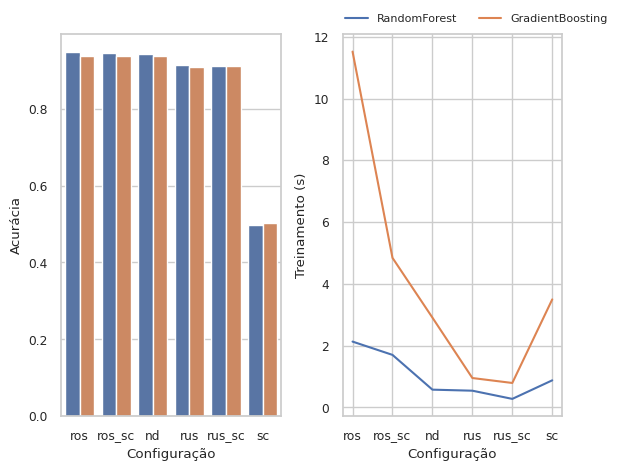

In [43]:

# cria o plot
fig, axes = plt.subplots(1, 2, figsize=(6.3, 4.8))

# adiciona os graficos
sns.barplot(
    x='Configuração',
    y='Acurácia',
    hue='Modelo',
    data=df_modelos,
    ax=axes[0]).legend_.remove()

sns.lineplot(
    x='Configuração',
    y='Treinamento (s)',
    hue='Modelo',
    data=df_modelos,
    ax=axes[1])

# altera a legenda
axes[1].legend(loc="lower center", bbox_to_anchor=(.61, 1),  fontsize='small', ncol=2, title=None, frameon=False,)

# altera o espacamento
plt.tight_layout()


  
  **Comentário:** Algumas observações principais sobre os indicadores de desempenho:
  1.  As configurações "ros" e "ros_sc" do GradientBoosting apresentam as maiores acurácias com aproximadamente `94%`.
  2. O GradientBoosting tende a exigir mais tempo de treinamento do que o RandomForest.
  3. Dados balanceados por Undersampling (rus) reduzem ligeiramente suas métricas.
  4. A ROC AUC é alta em todas as configurações, indicando uma boa capacidade de distinção entre as classes.


  <!--
  Comment: Some main observations on performance indicators:
  1.  The "ros" and "ros_sc" configurations of GradientBoosting have the highest accuracies with approximately 93%.
  2. GradientBoosting tends to require more training time than RandomForest.
  3. Data balanced by Undersampling (rus) slightly reduces its metrics.
  4. The ROC AUC is high in all configurations, indicating a good ability to distinguish between classes.
  -->


  
  <br>

  #### 7. Conclusão...

  Este foi um projeto para prever diferentes níveis anêmicos em crianças de 0 a 59 meses. Para isso, implementou-se dois modelos de aprendizado de máquina com 12 cofigurações distintas no total. Todo esse notebook demanda cerca de 50 segundos para ser executado e retorna uma precisão de 94% em suas previsões.
  
  No entanto, há margem para aprimoramentos. Para começar, as combinações de hiperparametros poderiam ser testadas através da busca bayesiana, busca aleatória ou busca de gradiente. Além disso, prever novos resultados via interface gráfica ou interação via console, melhoraria a experiência dos usuários.
  
  `*Overfitting, underfitting, importância das variáveis, normalização, one-hot-encoding e validação cruzada também poderiam ser aplicados.`

  Adicionalmente, o conjunto de dados seria concisamente mais rico se obtivesse mais variáveis laboratoriais, pois dados como a quantidade de ferro, zinco e glóbulos vermelhos também possuem um papel significativo na identificação da condição anêmica.

  Acredito que este seja apenas o ponto de partida para futuras explorações.
  
  <br>

  <!--
  This was a project to predict different levels of anemia in children aged 0 to 59 months. To do this, two machine learning models were implemented with a total of 12 different configurations. The whole notebook takes about 50 seconds to run and returns an accuracy of 93% in its predictions.
  
  However, there is room for improvement. For a start, hyperparameter combinations could be tested using Bayesian search, random search or gradient search. In addition, predicting new results via a graphical interface or console interaction would improve the user experience.
  
  *Overfitting, underfitting, variable importance, normalization, one-hot-encoding and cross-validation could also be applied.

  In addition, the data set would be concisely richer if more laboratory variables were obtained, since data such as the amount of iron, zinc and the amount of red blood cells also play a significant role in identifying anemic status.

  I believe that this is just the starting point for future explorations.
  -->